In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import matplotlib

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

matplotlib.rcParams.update({'font.size': 14})

In [11]:
# chain cut
F = 1/2
Re = 1.0
# number of beads
N = 64
Nx = 256
L = 2*Re

In [12]:
def calculate_mean_displacement(polymers_chains):
    # calculate the displacement as a function of the montecarlo step
    # args-> polymers_chains: array, contains the x,y,z coordinates of the desired point as  a function of
    #       montecarlo step for each polymer in the format [step, coordinate, polymer]
    # returns -> displacements_mean: array, average accros polymers of the displacement
    
    displacements = []
    # iterate over montecarlo steps
    for i in range(0,len(polymers_chains)):
        # displacement vector for all polymers
        disp_vector = polymers_chains[i,:,:] - polymers_chains[0,:,:]         
        # calcualte the magnitude of the displacement for all polymers
        displacements.append( np.sum(disp_vector*disp_vector, axis=0) )
        
    # calculcate the mean with format [steps, polymers], 
    displacements_mean = np.mean(displacements, axis=1)
    
    return displacements_mean


def clean_polymers(coord_polymer):
    # cleans the coordinates of the polymers cm / junction point positions
    coord_list = []
    for i in range(0,N_polymers):
        coord_list.append(coord_polymer[i*N_steps:(i+1)*N_steps])
    # stack the list into a 3d array
    # the format is [montecarlo step, spatial dimension, polymer]
    print(np.shape(coord_list))
    coord_array = np.dstack(coord_list)
    print(np.shape(coord_array))
    # remember to skip the first step_eq montecarlo steps to take only at equilibrium and skip some of the
    coord_clean = coord_array[step_eq:,:,:].copy()
    print(np.shape(coord_clean))
    
    return coord_clean

## Analysis without fields

In [13]:
id_string = 'even_longer_no_fields'

In [19]:

acceptance_ratios = np.loadtxt(id_string+'/acceptance_ratio.csv', delimiter=',')
delta_u_list = np.loadtxt(id_string+'/energy_changes.csv', delimiter=',')
u_list = np.loadtxt(id_string+'/energy_convergence.csv', delimiter=',')

montecarlo_chains = pd.read_pickle(id_string+'/montecarlo_chains.pkl')


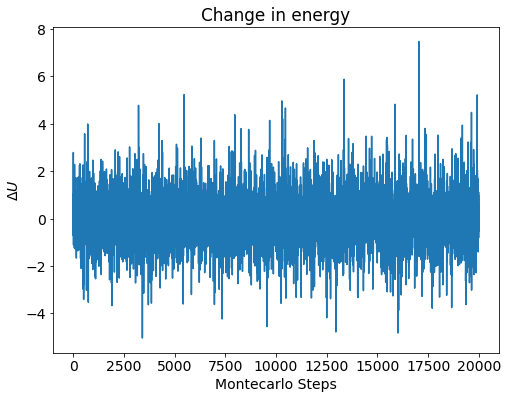

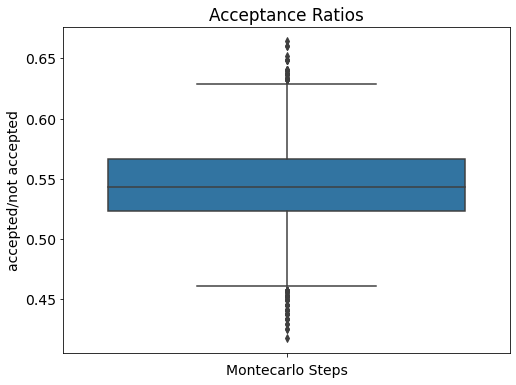

In [20]:
plt.figure(figsize=(8,6))
plt.plot(delta_u_list)
plt.title("Change in energy")
plt.xlabel("Montecarlo Steps")
plt.ylabel("$\Delta U$")


plt.figure(figsize=(8,6))
sns.boxplot(y=acceptance_ratios)
plt.title("Acceptance Ratios")
plt.xlabel("Montecarlo Steps")
plt.ylabel("accepted/not accepted")
plt.savefig('acceptance_ratios.png')


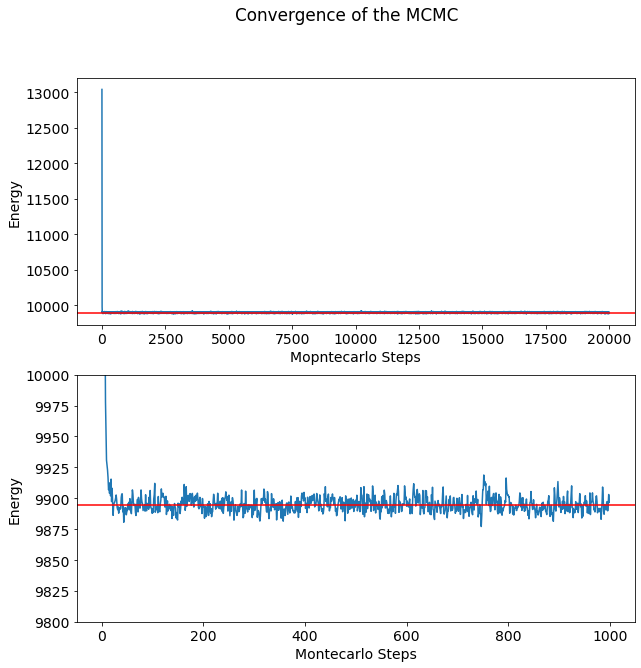

In [21]:

fig = plt.figure(figsize=(10,10))
plt.suptitle('Convergence of the MCMC')
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(u_list)
plt.axhline(np.mean(u_list), color ='r')
plt.xlabel('Mopntecarlo Steps')
plt.ylabel('Energy')


plt.subplot(2,1,2)
plt.plot(u_list[:1000])
plt.axhline(np.mean(u_list), color ='r')
plt.ylim(9800,10000)
plt.xlabel('Montecarlo Steps')
plt.ylabel('Energy')
plt.savefig('energy_convergence.png')


### Autocorrelation

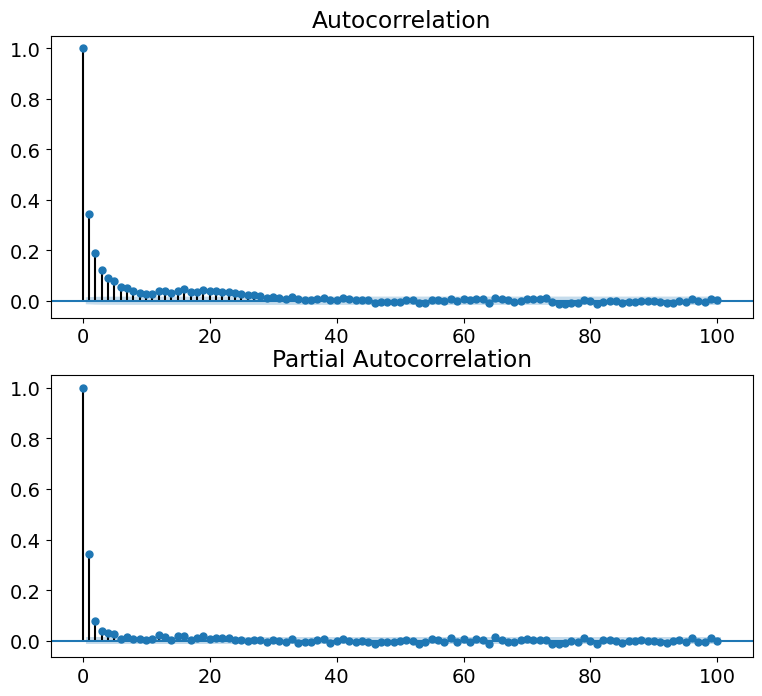

In [22]:
fig, axes = plt.subplots(2,1,figsize=(8,7), dpi= 100)
plt.tight_layout()
_ = plot_acf(u_list[100:], lags=100, ax=axes[0])
_ = plot_pacf(u_list[100:], lags=100, ax=axes[1])



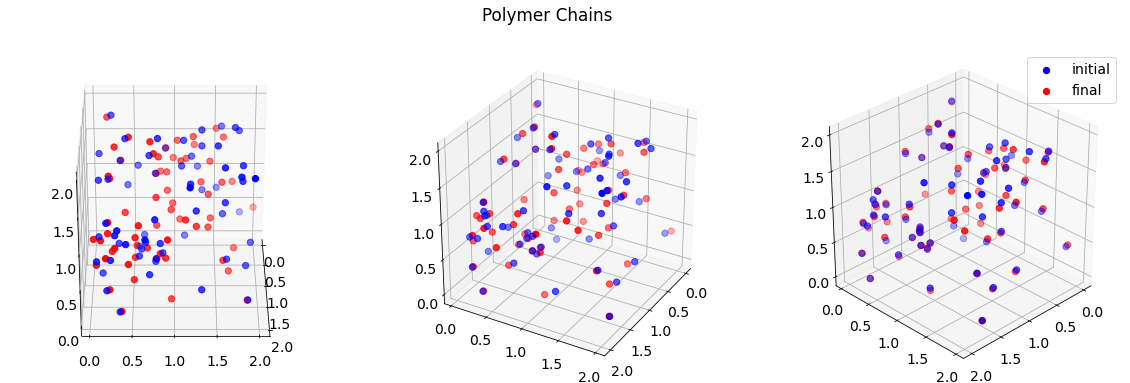

In [23]:
fig = plt.figure(figsize=(20,6))
plt.suptitle('Polymer Chains')
angles = [0, 30, 45]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], 
                 c = 'blue', label='initial', s=40);
    ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], 
                 c='red', label='final', s=40);
    
    i+=1
    
plt.legend()
plt.savefig(id_string+'polymer.png')



# Determine $\Delta_{max}$

In [ ]:
# define the parameters to clean up the arrays
#N_polymers = 128
N_polymers = 80
N_steps = 2000
# steps to skip to reach equilibirum
step_eq = 100
# steps to get uncorrelated samples
step_skip = 20

# create a t that reflects the number of steps
t = np.arange(step_eq,N_steps,step_skip)
len(t)

In [ ]:
deltas = pd.read_pickle('delta_center_masses.pkl')

# values used for the displacement
X = np.linspace(0,Nx, Nx)
X = X*L/Nx

dd = (X[1]-X[0])
delta_var = [dd*5,dd*10,dd*15, dd*20, dd*40]
d_str = '$\Delta_x$'
delta_strings = [ d_str+'*5', d_str+'*10',d_str+'*15', d_str+'*20',d_str+'*40']


In [ ]:
print(np.shape(deltas))
np.shape(deltas[0])
deltas_g = []

# define colors for out plots '#377eb8''#ff7f00'
CB_color_cycle = [  '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# center of mass for each diplacements
plt.figure(figsize=(10.5,7))
for i in range(0,len(deltas)):
    # clean up the data
    deltas_clean = clean_polymers(deltas[i])
    deltas_clean = deltas_clean[::step_skip,:,:]
    # calculate the displacement
    deltas_g.append(calculate_mean_displacement(deltas_clean))
    # plot
    plt.loglog(t,deltas_g[i], label=delta_strings[i], c = CB_color_cycle[i],linewidth=3.0)
    

plt.legend()
plt.xlabel('Montecarlo step')
plt.ylabel('$g_{cm}(t)$')
plt.title('Center of mass behaviour with $\Delta$')
plt.savefig('g_cm_deltas.png')

##  Center of mass no fields

In [ ]:
# define the parameters to clean up the arrays
N_polymers = 128
N_steps = 3500
# steps to skip to reach equilibirum
step_eq = 100
# steps to get uncorrelated samples
step_skip = 20

In [ ]:
# load data
cms = pd.read_pickle(id_string+'/center_masses.pkl')

junction_p = pd.read_pickle(id_string+'/junction_points.pkl')


In [ ]:
# calculate the center of mass displacement
cms_clean = clean_polymers(cms)
cms_clean = cms_clean[::step_skip,:,:]
cm_displacement = calculate_mean_displacement(cms_clean)

# calcualte the junction displacement
junction_clean = clean_polymers(junction_p)
junction_clean = junction_clean[::step_skip,:,:]
junction_displacement = calculate_mean_displacement(junction_clean)

# create a t that reflects the number of steps
t = np.arange(step_eq,N_steps,step_skip)

plt.figure(figsize=(10,6))
plt.loglog(t,cm_displacement, label='CM')
plt.loglog(t,junction_displacement, linestyle='dashed', label='junction')

plt.ylabel('$g_{cm}(t)$')
plt.xlabel('Montecarlo Step')
plt.title('Displacement')
plt.legend()

plt.savefig(id_string+'_displacements.png')

# With fields


In [ ]:
id_string = 'even_longer_fields'

In [ ]:
montecarlo_chains = pd.read_pickle(id_string+'/montecarlo_chains_polymers.pkl')

In [ ]:
# load data
cms = pd.read_pickle(id_string+'/center_masses.pkl')
cms = np.asarray(cms)

junction_p = pd.read_pickle(id_string+'/junction_points.pkl')
junction_p = np.asarray(junction_p)


In [ ]:
len(cm_displacement)

In [ ]:
# calculate the center of mass displacement
cms_clean = clean_polymers(cms)
cms_clean = cms_clean[::step_skip,:,:]
cm_displacement = calculate_mean_displacement(cms_clean)


# calcualte the junction displacement
junction_clean = clean_polymers(junction_p)
junction_clean = junction_clean[::step_skip,:,:]
junction_displacement = calculate_mean_displacement(junction_clean)


plt.figure(figsize=(8,6))
plt.loglog(t,cm_displacement, label='CM')
plt.loglog(t,junction_displacement, linestyle='dashed', label='junction')

plt.ylabel('$g_{cm}(t)$')
plt.xlabel('Montecarlo Step')
plt.title('Displacement')
plt.legend()

plt.savefig(id_string+'_displacements.png')

### density analysis

In [ ]:
def calculate_density_distribution(x, polymer_x ,sig):
    # calcualte the density distribution for the tensor containing all the polymer coordinates
    # adds a 1 in the x position where there is a polymer bead
    # args--> x: array, represents the discretization of the box the polymer is in
    #         polymer_x: array, rank 3 tensor containing the bead coordinates of every polymer
    #         sig: interval in which we check for the delta function
    
    density_matrix = np.zeros((len(x),N_polymers))
    # iterate over polimers
    for j in range(0,N_polymers):
        density_polymer = np.zeros(len(x))
        # choose the chain of a polymer
        x_chain =  polymer_x[:,0,j]
        # iterate over each bead of the current polymer
        for i in range(0,len(x_chain)):
            x0 = x_chain[i]
            # calculate the delta function for all points in the chain
            delta_f = np.zeros(len(x))
            density_mask = (x>=(x0-(1/2)*sig)) & (x<=(x0+(1/2)*sig))
            delta_f[density_mask] = 1
            density_polymer = density_polymer + delta_f

        density_matrix[:,j] = density_polymer

    return density_matrix

In [ ]:
chains_arr = np.dstack(montecarlo_chains)
np.shape(chains_arr)


In [ ]:
fig = plt.figure(figsize=(20,6))
plt.suptitle('Some chain')
angles = [0 , 65]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(chains_arr[:,0,0], chains_arr[:,1,0], chains_arr[:,2,0], 
                 c = 'blue', s=40);

    i+=1

In [ ]:
A_polymers = chains_arr[:int(N*F),:,:]
B_polymers = chains_arr[int(N*F):,:,:]

In [ ]:
Nx = 256
X = np.linspace(0,Nx, Nx)
X = X*L/Nx
X0 = X[0]
sigma = (X[1]- X[0])

# get the density distributions
a_density_dist = calculate_density_distribution(X, A_polymers ,sigma)
b_density_dist = calculate_density_distribution(X, B_polymers ,sigma)
# calculate the means
a_density_mean = np.mean(a_density_dist, axis=1)*L
b_density_mean = np.mean(b_density_dist, axis=1)*L

plt.figure(figsize=(7.5,6))
plt.scatter(X,b_density_mean+a_density_mean)
plt.title('Total Density')
plt.ylabel('$\phi_A(x) + \phi_B(x)$')
plt.xlabel('$x/R_e$')
plt.savefig('total_density_montecarlo.png')